#### Problem Description:
- Assign a given set of orders to plants and carriers to minimize cost.
- select the appropriate plant that processes the order
- select the port from which to send the order to its destination
#### Restrictions
- a given plant can only process certain products
- each plant is only connected to certain ports. 
- some customers have a vendor managed inventory (VMI) which means that they can only be serviced by a certain plant.

In [1]:
!pip install openpyxl

In [2]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import seaborn as sns
import networkx as nx

In [3]:
data = pd.ExcelFile("../input/supply-chain-data/Supply chain logisitcs problem.xlsx")

In [4]:
plant_ports = data.parse("PlantPorts")
order_list = data.parse("OrderList")
products_per_plant = data.parse('ProductsPerPlant')
vmi_plants = data.parse("VmiCustomers")
freight_rates = data.parse("FreightRates")
wh_costs = data.parse("WhCosts")
wh_capacities = data.parse("WhCapacities")

In [5]:
plant_ports

,Plant Code,Port
0,PLANT01,PORT01
1,PLANT01,PORT02
2,PLANT02,PORT03
3,PLANT03,PORT04
4,PLANT04,PORT05
5,PLANT05,PORT06
6,PLANT06,PORT06
7,PLANT07,PORT01
8,PLANT07,PORT02
9,PLANT08,PORT04


In [6]:
order_list

,Order ID,Order Date,Origin Port,Carrier,TPT,Service Level,Ship ahead day count,Ship Late Day count,Customer,Product ID,Plant Code,Destination Port,Unit quantity,Weight
0,1.447296e+09,2013-05-26,PORT09,V44_3,1,CRF,3,0,V55555_53,1700106,PLANT16,PORT09,808,14.300000
1,1.447158e+09,2013-05-26,PORT09,V44_3,1,CRF,3,0,V55555_53,1700106,PLANT16,PORT09,3188,87.940000
2,1.447139e+09,2013-05-26,PORT09,V44_3,1,CRF,3,0,V55555_53,1700106,PLANT16,PORT09,2331,61.200000
3,1.447364e+09,2013-05-26,PORT09,V44_3,1,CRF,3,0,V55555_53,1700106,PLANT16,PORT09,847,16.160000
4,1.447364e+09,2013-05-26,PORT09,V44_3,1,CRF,3,0,V55555_53,1700106,PLANT16,PORT09,2163,52.340000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9210,1.447305e+09,2013-05-26,PORT04,V444_1,1,DTD,5,0,V55555555555555_8,1683388,PLANT03,PORT09,339,2.354118
9211,1.447319e+09,2013-05-26,PORT04,V444_1,1,DTD,5,0,V55555555555555_8,1683388,PLANT03,PORT09,339,2.354118
9212,1.447322e+09,2013-05-26,PORT04,V444_1,1,DTD,5,0,V55555555555555_8,1683388,PLANT03,PORT09,245,0.294265
9213,1.447145e+09,2013-05-26,PORT04,V444_1,1,DTD,5,0,V55555555555555_8,1683430,PLANT03,PORT09,278,2.480000


In [7]:
products_per_plant

,Plant Code,Product ID
0,PLANT15,1698815
1,PLANT17,1664419
2,PLANT17,1664426
3,PLANT17,1672826
4,PLANT17,1674916
...,...,...
2031,PLANT04,1699951
2032,PLANT04,1699952
2033,PLANT04,1699953
2034,PLANT04,1699954


In [8]:
vmi_plants

,Plant Code,Customers
0,PLANT02,V5555555555555_16
1,PLANT02,V555555555555555_29
2,PLANT02,V555555555_3
3,PLANT02,V55555555555555_8
4,PLANT02,V55555555_9
5,PLANT02,V55555_10
6,PLANT02,V55555555_5
7,PLANT06,V555555555555555_18
8,PLANT06,V55555_10
9,PLANT10,V555555555555555_29


In [9]:
freight_rates

,Carrier,orig_port_cd,dest_port_cd,minm_wgh_qty,max_wgh_qty,svc_cd,minimum cost,rate,mode_dsc,tpt_day_cnt,Carrier type
0,V444_6,PORT08,PORT09,250.0,499.99,DTD,43.2272,0.7132,AIR,2,V88888888_0
1,V444_6,PORT08,PORT09,65.0,69.99,DTD,43.2272,0.7512,AIR,2,V88888888_0
2,V444_6,PORT08,PORT09,60.0,64.99,DTD,43.2272,0.7892,AIR,2,V88888888_0
3,V444_6,PORT08,PORT09,50.0,54.99,DTD,43.2272,0.8272,AIR,2,V88888888_0
4,V444_6,PORT08,PORT09,35.0,39.99,DTD,43.2272,1.0552,AIR,2,V88888888_0
...,...,...,...,...,...,...,...,...,...,...,...
1535,V444_8,PORT03,PORT09,0.0,99.99,DTD,29.3392,0.4116,AIR,0,V88888888_0
1536,V444_8,PORT03,PORT09,500.0,1999.99,DTD,29.3392,0.3112,AIR,0,V88888888_0
1537,V444_8,PORT03,PORT09,250.0,499.99,DTD,29.3392,0.4116,AIR,0,V88888888_0
1538,V444_8,PORT03,PORT09,2000.0,99999.99,DTD,29.3392,0.3112,AIR,0,V88888888_0


In [10]:
wh_costs

,WH,Cost/unit
0,PLANT15,1.415063
1,PLANT17,0.428947
2,PLANT18,2.036254
3,PLANT05,0.488144
4,PLANT02,0.477504
5,PLANT01,0.566976
6,PLANT06,0.554088
7,PLANT10,0.493582
8,PLANT07,0.371424
9,PLANT14,0.634330


In [11]:
wh_capacities

,Plant ID,Daily Capacity
0,PLANT15,11
1,PLANT17,8
2,PLANT18,111
3,PLANT05,385
4,PLANT02,138
5,PLANT01,1070
6,PLANT06,49
7,PLANT10,118
8,PLANT07,265
9,PLANT14,549


In [12]:
def column_name_change(sheet):
    return [column.replace(" ", "_").lower() for column in sheet.columns]

In [13]:
# Changing column names in each sheet
order_list.columns = column_name_change(order_list)
products_per_plant.columns = column_name_change(products_per_plant)
plant_ports.columns = column_name_change(plant_ports)
vmi_plants.columns= column_name_change(vmi_plants)
freight_rates.columns = column_name_change(freight_rates)
wh_costs.columns = column_name_change(wh_costs)
wh_capacities.columns = column_name_change(wh_capacities)

In [14]:
plant_ports

,plant_code,port
0,PLANT01,PORT01
1,PLANT01,PORT02
2,PLANT02,PORT03
3,PLANT03,PORT04
4,PLANT04,PORT05
5,PLANT05,PORT06
6,PLANT06,PORT06
7,PLANT07,PORT01
8,PLANT07,PORT02
9,PLANT08,PORT04


In [15]:
network_graph_plant_ports = nx.from_pandas_edgelist(plant_ports, source='plant_code', target='port')

In [16]:
network_graph_plant_ports.degree

DegreeView({'PLANT01': 2, 'PORT01': 3, 'PORT02': 3, 'PLANT02': 1, 'PORT03': 1, 'PLANT03': 1, 'PORT04': 7, 'PLANT04': 1, 'PORT05': 1, 'PLANT05': 1, 'PORT06': 2, 'PLANT06': 1, 'PLANT07': 2, 'PLANT08': 1, 'PLANT09': 1, 'PLANT10': 2, 'PLANT11': 1, 'PLANT12': 1, 'PLANT13': 1, 'PLANT14': 1, 'PORT07': 1, 'PLANT15': 1, 'PORT08': 1, 'PLANT16': 1, 'PORT09': 1, 'PLANT17': 1, 'PORT10': 1, 'PLANT18': 1, 'PORT11': 1, 'PLANT19': 1})

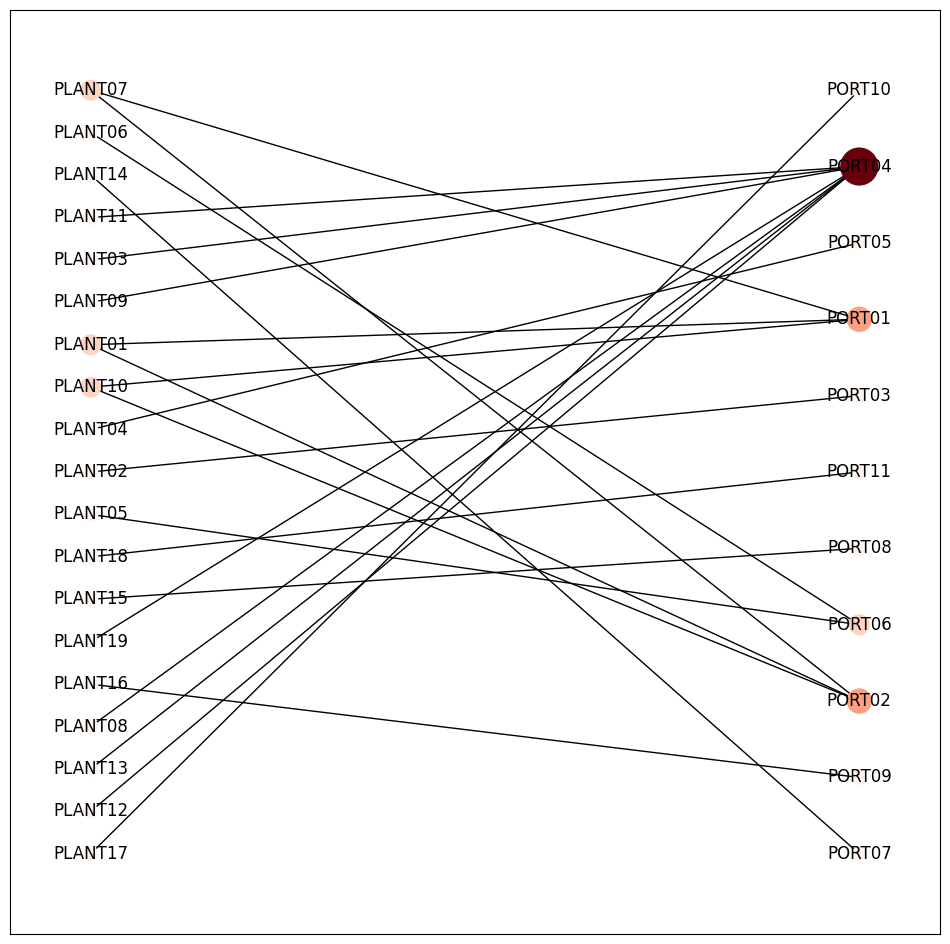

In [17]:
fig, ax = plt.subplots(figsize=(12, 12))
# ax.set_facecolor("Yellow")
layout = nx.bipartite_layout(network_graph_plant_ports, plant_ports.plant_code)
# print(layout)
for i in layout:
    if i.startswith("Plant"):
        layout[i][0] -= 0.1
    else:
        layout[i][0] += 0.1
degrees = dict(network_graph_plant_ports.degree)
maps = [value*100 for value in degrees.values()]

cmap = plt.cm.Reds
kwargs = {"pos":layout, "ax":ax}

nx.draw_networkx_nodes(network_graph_plant_ports, node_size=maps, node_color=maps, cmap=cmap, **kwargs)
nx.draw_networkx_edges(network_graph_plant_ports, **kwargs)
nx.draw_networkx_labels(network_graph_plant_ports, pos=layout)
plt.show()